### Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import gc
import warnings
import logging
from datetime import datetime
warnings.filterwarnings('ignore')
from torch.cuda.amp import autocast, GradScaler
import json

In [ ]:
data_path = "/content/drive/MyDrive/Colab Notebooks/rec/Data"

### Split Data

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


### Process Object

### Read in Data and Write Out

In [ ]:
train_data = pd.read_pickle(os.path.join(data_path, 'train_shrunk50cols.pkl'))
val_data = pd.read_pickle(os.path.join(data_path, 'val_shrunk50cols.pkl'))

y_train = pd.read_pickle(os.path.join(data_path, 'y_train_scaled.pkl'))
y_val = pd.read_pickle(os.path.join(data_path, 'y_val_scaled.pkl'))


with open(os.path.join(data_path, 'array_features.json'), 'r') as f:
    array_features = json.load(f)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5595198 entries, 687866 to 969348
Data columns (total 50 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   ratio_bucket_0_1_to_bucket_4_5             float64
 1   year_avg_diff_bucket_0_1_vs_bucket_4_5     float64
 2   runtime_avg_diff_bucket_0_1_vs_bucket_4_5  float64
 3   rating_avg_diff_bucket_0_1_vs_bucket_4_5   float64
 4   ratio_bucket_2_3_to_bucket_4_5             float64
 5   year_avg_diff_bucket_2_3_vs_bucket_4_5     float64
 6   runtime_avg_diff_bucket_2_3_vs_bucket_4_5  float64
 7   rating_avg_diff_bucket_2_3_vs_bucket_4_5   float64
 8   rating                                     float32
 9   total_ratings                              float64
 10  rating_avg                                 float64
 11  rating_std                                 float64
 12  bucket_4_5_movie_ids                       object 
 13  bucket_4_5_count                           

In [ ]:
columns = train_data.columns
print(f"Before: {array_features}")
for key in list(array_features.keys()):
  if key not in columns:
    array_features.pop(key)
print(f"After: {array_features}")

Before: {'bucket_0_1_movie_ids': {'max_len': 16, 'vocab_size': 28329761, 'actual_max_len': 4578}, 'bucket_0_1_top_directors': {'max_len': 3, 'vocab_size': 89770, 'actual_max_len': 3}, 'bucket_0_1_top_writers': {'max_len': 3, 'vocab_size': 89890, 'actual_max_len': 3}, 'bucket_2_3_movie_ids': {'max_len': 16, 'vocab_size': 28912859, 'actual_max_len': 18781}, 'bucket_2_3_top_directors': {'max_len': 3, 'vocab_size': 89770, 'actual_max_len': 3}, 'bucket_2_3_top_writers': {'max_len': 3, 'vocab_size': 89877, 'actual_max_len': 3}, 'bucket_4_5_movie_ids': {'max_len': 16, 'vocab_size': 28912859, 'actual_max_len': 5511}, 'bucket_4_5_top_directors': {'max_len': 3, 'vocab_size': 89770, 'actual_max_len': 3}, 'bucket_4_5_top_writers': {'max_len': 3, 'vocab_size': 89879, 'actual_max_len': 3}, 'genres': {'max_len': 3, 'vocab_size': 29, 'actual_max_len': 3}, 'directors': {'max_len': 16, 'vocab_size': 89903, 'actual_max_len': 74}, 'writers': {'max_len': 16, 'vocab_size': 89918, 'actual_max_len': 63}}
Afte

In [ ]:
with open(os.path.join(data_path, 'array_features_shrunk.json'), 'w') as f:
    json.dump(array_features, f)

###Exctract Dataset Information

In [ ]:
array_features.keys()

dict_keys(['bucket_4_5_movie_ids', 'bucket_4_5_top_directors', 'bucket_4_5_top_writers', 'genres', 'directors', 'writers'])

In [ ]:
target = "rating"
objects = [col for col in train_data.columns if train_data[col].dtype == "object"]
categorical = "tconst_numeric"
numerical = [col for col in train_data.columns if col not in objects + [categorical] + [target]]
print(f"Target: {target}")
print(f"Objects: {objects}")
print(f"Categorical: {categorical}")
print(f"Numerical: {numerical}")

Target: rating
Objects: ['bucket_4_5_movie_ids', 'bucket_4_5_top_directors', 'bucket_4_5_top_writers', 'genres', 'directors', 'writers']
Categorical: tconst_numeric
Numerical: ['ratio_bucket_0_1_to_bucket_4_5', 'year_avg_diff_bucket_0_1_vs_bucket_4_5', 'runtime_avg_diff_bucket_0_1_vs_bucket_4_5', 'rating_avg_diff_bucket_0_1_vs_bucket_4_5', 'ratio_bucket_2_3_to_bucket_4_5', 'year_avg_diff_bucket_2_3_vs_bucket_4_5', 'runtime_avg_diff_bucket_2_3_vs_bucket_4_5', 'rating_avg_diff_bucket_2_3_vs_bucket_4_5', 'total_ratings', 'rating_avg', 'rating_std', 'bucket_4_5_count', 'bucket_4_5_year_avg', 'bucket_4_5_runtime_avg', 'bucket_4_5_rating_avg', 'bucket_4_5_numvotes_avg', 'high_vs_low_ratio', 'rating_proportions_5.0', 'rating_proportions_4.0', 'rating_proportions_1.0', 'rating_proportions_3.0', 'rating_proportions_2.0', 'rating_proportions_3.5', 'rating_proportions_2.5', 'rating_proportions_4.5', 'rating_proportions_0.5', 'rating_proportions_1.5', 'bucket_4_5_genre_proportions_Drama', 'bucket_

In [ ]:
cat_features = {}
max_val_train = train_data[categorical].max() if not train_data.empty else 0
max_val_val = val_data[categorical].max() if not val_data.empty else 0
max_val = max(max_val_train, max_val_val)

# Store vocab size for embeddings (max_val + 1 for 0-indexed embedding)
cat_features[categorical] = int(max_val) + 1

In [ ]:
field_dims = {}
for col in numerical:
    field_dims[col] = 1  # Numerical features have dimension 1

for col, vocab_size in cat_features.items():
    field_dims[col] = vocab_size

for col, info in array_features.items():
    field_dims[col] = info['max_len']

### Create Datasets

In [ ]:
class DeepFMDataset(Dataset):
    def __init__(self, X, y, numeric_cols, categorical_cols, array_cols, array_features):
        self.X = X
        self.y = y
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.array_cols = array_cols
        self.array_features = array_features  # Store the array_features dictionary in the class

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Get numerical features
        if self.numeric_cols:
            row = self.X.iloc[idx]
            numerical_values = np.array([float(row[col]) for col in self.numeric_cols], dtype=np.float32)
            # Clean any potential NaNs or Infs
            numerical_values = np.nan_to_num(numerical_values, nan=0.0, posinf=0.0, neginf=0.0)
            numerical_features = torch.tensor(numerical_values, dtype=torch.float32)
        else:
            numerical_features = torch.tensor([], dtype=torch.float32)

        # Get categorical features
        if self.categorical_cols:
            if isinstance(self.categorical_cols, list):
                categorical_values = np.array([int(self.X.iloc[idx][col]) for col in self.categorical_cols], dtype=np.int64)
            else:
                categorical_values = np.array([int(self.X.iloc[idx][self.categorical_cols])], dtype=np.int64)

            categorical_features = torch.tensor(categorical_values, dtype=torch.long)
        else:
            categorical_features = torch.tensor([], dtype=torch.long)

        # Get array features
        array_features_dict = {}
        if self.array_cols:
            for col in self.array_cols:
                arr = self.X.iloc[idx][col]
                if isinstance(arr, np.ndarray):
                    # Handle empty arrays
                    if arr.size == 0:
                        # Create a default empty array with proper dimensions
                        arr = np.zeros(1, dtype=np.float32)

                    # Continue with your existing max_len logic
                    max_len = self.array_features[col]['max_len']
                    if len(arr) > max_len:
                        arr = arr[:max_len]
                    array_features_dict[col] = torch.tensor(arr.astype(np.float32), dtype=torch.float32)
                else:
                    # Handle non-array case
                    array_features_dict[col] = torch.tensor(np.zeros(1, dtype=np.float32), dtype=torch.float32)
        # Get the target
        target = torch.tensor(float(self.y.iloc[idx]), dtype=torch.float32)

        return numerical_features, categorical_features, array_features_dict, target

In [ ]:
train_dataset = DeepFMDataset(
    train_data,
    y_train,
    numerical,
    categorical,
    objects,
    array_features
)

val_dataset = DeepFMDataset(
    val_data,
    y_val,
    numerical,
    categorical,
    objects,
    array_features
)


In [ ]:
def collate_fn(batch):
    numerical_features = []
    categorical_features = []
    array_features_dict = {col: [] for col in objects}
    targets = []

    for numerical, categorical, arrays, target in batch:
        numerical_features.append(numerical)
        categorical_features.append(categorical)
        targets.append(target)

        # Process array features with proper empty array handling
        for col in objects:
            if col in arrays:
                # Handle case where array is empty or invalid
                if arrays[col].numel() == 0:
                    # Create a zero tensor of the required length
                    arrays[col] = torch.zeros(array_features[col]['max_len'], dtype=torch.float32)

                # Truncate if longer than our max length
                max_len = array_features[col]['max_len']
                if arrays[col].shape[0] > max_len:
                    arrays[col] = arrays[col][:max_len]

                # Pad if shorter than our max length
                elif arrays[col].shape[0] < max_len:
                    padding = torch.zeros(max_len - arrays[col].shape[0], dtype=torch.float32)
                    arrays[col] = torch.cat([arrays[col], padding])

                # Ensure values are valid (no NaN/Inf)
                arrays[col] = torch.nan_to_num(arrays[col], nan=0.0, posinf=0.0, neginf=0.0)

                array_features_dict[col].append(arrays[col])
            else:
                # Handle case where the column is missing completely
                default_tensor = torch.zeros(array_features[col]['max_len'], dtype=torch.float32)
                array_features_dict[col].append(default_tensor)

    # Stack the features and targets with proper error handling
    if numerical_features and all(f.numel() > 0 for f in numerical_features):
        # Check for NaN/Inf values before stacking
        for i, feat in enumerate(numerical_features):
            numerical_features[i] = torch.nan_to_num(feat, nan=0.0, posinf=0.0, neginf=0.0)
        numerical_batch = torch.stack(numerical_features)
    else:
        numerical_batch = None

    if categorical_features and all(f.numel() > 0 for f in categorical_features):
        categorical_batch = torch.stack(categorical_features)
    else:
        categorical_batch = None

    # Clean and stack array features
    for col in array_features_dict:
        if array_features_dict[col]:
            # Check for and handle any invalid tensors before stacking
            for i, tensor in enumerate(array_features_dict[col]):
                if torch.isnan(tensor).any() or torch.isinf(tensor).any():
                    array_features_dict[col][i] = torch.nan_to_num(tensor, nan=0.0, posinf=0.0, neginf=0.0)

    # Final assembly of array batches
    array_batches = {col: torch.stack(tensors) if tensors else torch.zeros((len(batch), array_features[col]['max_len']), dtype=torch.float32)
                     for col, tensors in array_features_dict.items()}

    targets_batch = torch.stack(targets)

    return numerical_batch, categorical_batch, array_batches, targets_batch

In [ ]:
batch_size = 512
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=False,
    num_workers=3

)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=False,
    num_workers=3
)


In [ ]:
class FactorizationMachine(nn.Module):
    def __init__(self):
        super(FactorizationMachine, self).__init__()

    def forward(self, x):
        """
        x: A tensor of shape (batch_size, num_fields, embedding_dim)
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        interaction = square_of_sum - sum_of_square
        return 0.5 * torch.sum(interaction, dim=1, keepdim=True)

class DeepFM(nn.Module):
    def __init__(self, field_dims, cat_features, array_features,
                 embedding_dim=16, mlp_dims=(128, 64), dropout=0.2):
        super(DeepFM, self).__init__()
        self.cat_features = cat_features
        self.array_features = array_features
        self.embedding_dim = embedding_dim

        # Embedding layers for categorical features
        self.embedding_dict = nn.ModuleDict()
        for col, vocab_size in cat_features.items():
            self.embedding_dict[col] = nn.Embedding(vocab_size, embedding_dim)

        # Embedding layers for array features
        self.array_embedding_dict = nn.ModuleDict()
        for col, info in array_features.items():
            # For array features, we need embeddings for each possible ID
            # Since the array contains IDs, we need to estimate a reasonable vocab size
            # Using 10000 as a default maximum ID value if not specified
            vocab_size = info.get('vocab_size', 10000)
            self.array_embedding_dict[col] = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Linear part for numeric features
        self.numeric_linear = nn.Linear(len(field_dims) - len(cat_features) - len(array_features), 1)

        # First-order part for categorical features
        self.cat_linear_dict = nn.ModuleDict()
        for col in cat_features:
            self.cat_linear_dict[col] = nn.Embedding(cat_features[col], 1)

        # FM part
        self.fm = FactorizationMachine()

        # Deep part (MLP)
        self.mlp_input_dim = (len(cat_features) + len(array_features)) * embedding_dim + (len(field_dims) - len(cat_features) - len(array_features))
        mlp_layers = []
        input_dim = self.mlp_input_dim
        for hidden_dim in mlp_dims:
            mlp_layers.append(nn.Linear(input_dim, hidden_dim))
            mlp_layers.append(nn.BatchNorm1d(hidden_dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))
            input_dim = hidden_dim
        mlp_layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, numerical_features, categorical_features, array_features_dict):
        """
        numerical_features: Tensor of shape (batch_size, num_numerical_features)
        categorical_features: Tensor of shape (batch_size, num_categorical_features)
        array_features_dict: Dictionary of tensors for array features
            Each tensor has shape (batch_size, max_len)
        """
        # Linear part (first-order)
        linear_part = 0
        if numerical_features is not None:
            linear_part += self.numeric_linear(numerical_features)

        # Process categorical features
        categorical_embeddings = []
        categorical_first_order = 0

        if categorical_features is not None and categorical_features.numel() > 0:
            for i, col in enumerate(self.cat_features):
                # First order
                categorical_first_order += self.cat_linear_dict[col](categorical_features[:, i]).squeeze(1).unsqueeze(-1)

                # Get embeddings for deep and FM parts
                embedding = self.embedding_dict[col](categorical_features[:, i])
                categorical_embeddings.append(embedding.unsqueeze(1))

        # Process array features (mean pooling over embeddings) - FIXED VERSION
        array_embeddings = []
        for col, tensor in array_features_dict.items():
            # Ensure tensor is valid - convert NaN or invalid values to zeros
            tensor = torch.nan_to_num(tensor, nan=0.0, posinf=0.0, neginf=0.0)

            # Convert to long type safely by first clamping to valid range
            max_index = self.array_embedding_dict[col].weight.size(0) - 1
            tensor_clamped = torch.clamp(tensor, 0, max_index).long()

            # Pass to embedding layer
            embedded = self.array_embedding_dict[col](tensor_clamped)  # (batch_size, max_len, embedding_dim)

            # Create mask for padding values (0s) - safely
            mask = (tensor_clamped != 0).float().unsqueeze(-1)  # (batch_size, max_len, 1)

            # Apply mask to embeddings
            masked_embedded = embedded * mask

            # Calculate mean - sum over max_len dimension and divide by count of non-padding elements
            sum_embedded = torch.sum(masked_embedded, dim=1)  # (batch_size, embedding_dim)
            count_non_padding = torch.sum(mask, dim=1) + 1e-10  # Add small epsilon to avoid division by zero
            pooled = sum_embedded / count_non_padding  # (batch_size, embedding_dim)

            array_embeddings.append(pooled.unsqueeze(1))

        linear_part = linear_part + categorical_first_order

        # FM part
        fm_embeddings = []
        if categorical_embeddings:
            fm_embeddings.extend(categorical_embeddings)
        if array_embeddings:
            fm_embeddings.extend(array_embeddings)

        if fm_embeddings:
            fm_input = torch.cat(fm_embeddings, dim=1)
            fm_part = self.fm(fm_input)
        else:
            fm_part = torch.zeros(numerical_features.shape[0], 1, device=numerical_features.device)

        # Deep part
        deep_input = []
        if numerical_features is not None:
            deep_input.append(numerical_features)

        if categorical_embeddings:
            cat_embeddings_concat = torch.cat([emb.squeeze(1) for emb in categorical_embeddings], dim=1)
            deep_input.append(cat_embeddings_concat)

        if array_embeddings:
            array_embeddings_concat = torch.cat([emb.squeeze(1) for emb in array_embeddings], dim=1)
            deep_input.append(array_embeddings_concat)

        if deep_input:
            deep_input_concat = torch.cat(deep_input, dim=1)
            deep_part = self.mlp(deep_input_concat)
        else:
            deep_part = torch.zeros(numerical_features.shape[0], 1, device=numerical_features.device)

        # Final prediction
        output = linear_part + fm_part + deep_part
        return output.squeeze(1)

### Training Loop

In [ ]:
def train_model_enhanced(train_loader, val_loader, field_dims, cat_features, array_features,
                         embedding_dim=16, mlp_dims=(128, 64), dropout=0.2,
                         learning_rate=0.001, epochs=50, patience=5, checkpoint_dir='models',
                         checkpoint_interval=1, weight_decay=1e-5, lr_scheduler_factor=0.3,
                         lr_scheduler_patience=2, scheduler_warmup_steps=1000, resume_training=True):
    """
    Train the DeepFM model with:
    - Mixed precision training
    - Regular checkpointing
    - Google Drive backup for all checkpoints
    - Memory optimization
    """
    # Mount Google Drive and create backup directory
    from google.colab import drive
    import shutil

    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Create backup directory in Google Drive
    drive_backup_dir = '/content/drive/MyDrive/deepfm_checkpoints'
    os.makedirs(drive_backup_dir, exist_ok=True)
    print(f"Checkpoint backups will be saved to: {drive_backup_dir}")

    # Create local checkpoint directory
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Create model
    model = DeepFM(
        field_dims=field_dims,
        cat_features=cat_features,
        array_features=array_features,
        embedding_dim=embedding_dim,
        mlp_dims=mlp_dims,
        dropout=dropout
    ).to(device)

    # Optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )

    # Initialize gradient scaler for mixed precision
    scaler = GradScaler()

    # Training loop variables
    best_val_loss = float('inf')
    early_stopping_counter = 0
    train_losses = []
    val_losses = []
    global_step = 0  # Track total steps for checkpointing

    # Helper function to backup to Google Drive
    def backup_to_drive(local_path, filename):
        drive_path = os.path.join(drive_backup_dir, filename)
        try:
            shutil.copy2(local_path, drive_path)
            logger.info(f"Backed up {filename} to Google Drive")
            return True
        except Exception as e:
            logger.error(f"Failed to backup {filename} to Google Drive: {e}")
            return False

    # Try to load from checkpoint if it exists and resume_training is True
    start_epoch = 0
    checkpoint_path = os.path.join(checkpoint_dir, 'deepfm_checkpoint.pth')
    if os.path.isfile(checkpoint_path) and resume_training:
        try:
            logger.info(f"Loading checkpoint from {checkpoint_path}")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            if 'scaler' in checkpoint:
                scaler.load_state_dict(checkpoint['scaler'])
            start_epoch = checkpoint['epoch'] + 1
            global_step = checkpoint.get('global_step', 0)
            best_val_loss = checkpoint['best_val_loss']
            train_losses = checkpoint['train_losses']
            val_losses = checkpoint['val_losses']
            if 'scheduler' in checkpoint:
                scheduler.load_state_dict(checkpoint['scheduler'])
            logger.info(f"Resuming training from epoch {start_epoch}, global step {global_step}")
        except Exception as e:
            logger.error(f"Error loading checkpoint: {e}")
            start_epoch = 0
            global_step = 0

    # Setup tensorboard writer for logging
    try:
        from torch.utils.tensorboard import SummaryWriter
        writer = SummaryWriter(log_dir=os.path.join(checkpoint_dir, 'tensorboard'))
        use_tensorboard = True
    except ImportError:
        logger.warning("Tensorboard not available. Install with: pip install tensorboard")
        use_tensorboard = False

    # Training loop
    for epoch in range(start_epoch, epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_batches = 0
        epoch_start_time = datetime.now()

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for numerical, categorical, array_batches, targets in train_progress:
            # Move data to device
            if numerical is not None:
                numerical = numerical.to(device, non_blocking=True)
            if categorical is not None:
                categorical = categorical.to(device, non_blocking=True)
            array_batches = {col: tensor.to(device, non_blocking=True) for col, tensor in array_batches.items()}
            targets = targets.to(device, non_blocking=True)

            # Forward pass with autocast (mixed precision)
            optimizer.zero_grad()
            with autocast():  # Mixed precision
                outputs = model(numerical, categorical, array_batches)
                loss = criterion(outputs, targets)

            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Update statistics
            train_loss += loss.item()
            train_batches += 1
            train_progress.set_postfix({"Loss": train_loss/train_batches})

            global_step += 1

            # Step-level checkpoint (save less frequently to avoid IO overhead)
            if global_step % (len(train_loader) * checkpoint_interval) == 0:
                step_filename = f'deepfm_step_{global_step}.pth'
                step_checkpoint_path = os.path.join(checkpoint_dir, step_filename)
                torch.save({
                    'epoch': epoch,
                    'global_step': global_step,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler': scaler.state_dict(),
                    'loss': loss.item(),
                }, step_checkpoint_path)
                logger.info(f"Step checkpoint saved at step {global_step}")

                # Backup to Google Drive
                backup_to_drive(step_checkpoint_path, step_filename)

            # Log to tensorboard
            if use_tensorboard and global_step % 100 == 0:
                writer.add_scalar('Train/BatchLoss', loss.item(), global_step)

        # End of epoch processing
        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)
        epoch_time = datetime.now() - epoch_start_time

        # Validation phase
        model.eval()
        val_loss = 0
        val_batches = 0
        val_start_time = datetime.now()

        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
        with torch.no_grad():
            for numerical, categorical, array_batches, targets in val_progress:
                # Move data to device
                if numerical is not None:
                    numerical = numerical.to(device, non_blocking=True)
                if categorical is not None:
                    categorical = categorical.to(device, non_blocking=True)
                array_batches = {col: tensor.to(device, non_blocking=True) for col, tensor in array_batches.items()}
                targets = targets.to(device, non_blocking=True)

                # Forward pass with mixed precision
                with autocast():
                    outputs = model(numerical, categorical, array_batches)
                    loss = criterion(outputs, targets)

                # Update statistics
                val_loss += loss.item()
                val_batches += 1
                val_progress.set_postfix({"Loss": val_loss/val_batches})

        # Calculate average validation loss
        avg_val_loss = val_loss / val_batches
        val_losses.append(avg_val_loss)
        val_time = datetime.now() - val_start_time

        # Update learning rate scheduler
        scheduler.step(avg_val_loss)

        # Print epoch statistics
        logger.info(f"Epoch {epoch+1}/{epochs} - "
                    f"Train Loss: {avg_train_loss:.6f} ({epoch_time}), "
                    f"Val Loss: {avg_val_loss:.6f} ({val_time})")

        # Log to tensorboard
        if use_tensorboard:
            writer.add_scalar('Train/EpochLoss', avg_train_loss, epoch)
            writer.add_scalar('Val/Loss', avg_val_loss, epoch)
            writer.add_scalar('LR', optimizer.param_groups[0]['lr'], epoch)

        # Save loss data to CSV
        loss_csv_filename = f'losses_up_to_epoch_{epoch+1}.csv'
        loss_csv_path = os.path.join(checkpoint_dir, loss_csv_filename)
        with open(loss_csv_path, 'w') as f:
            f.write("epoch,train_loss,val_loss\n")
            for i, (t_loss, v_loss) in enumerate(zip(train_losses, val_losses)):
                f.write(f"{i+1},{t_loss},{v_loss}\n")

        # Backup loss CSV to Google Drive
        backup_to_drive(loss_csv_path, loss_csv_filename)

        # Save comprehensive checkpoint after each epoch
        checkpoint_filename = 'deepfm_checkpoint.pth'
        checkpoint = {
            'epoch': epoch,
            'global_step': global_step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'scaler': scaler.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'hyperparams': {
                'embedding_dim': embedding_dim,
                'mlp_dims': mlp_dims,
                'dropout': dropout,
                'learning_rate': learning_rate,
            }
        }
        torch.save(checkpoint, checkpoint_path)
        backup_to_drive(checkpoint_path, checkpoint_filename)

        # Save epoch-specific checkpoint for backup
        epoch_filename = f'deepfm_epoch_{epoch+1}.pth'
        epoch_checkpoint_path = os.path.join(checkpoint_dir, epoch_filename)
        torch.save(checkpoint, epoch_checkpoint_path)
        logger.info(f"Epoch {epoch+1} checkpoint saved")
        backup_to_drive(epoch_checkpoint_path, epoch_filename)

        # Create and save loss curve plot
        plot_filename = f'loss_curves_epoch_{epoch+1}.png'
        plot_path = os.path.join(checkpoint_dir, plot_filename)
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss (up to epoch {epoch+1})')
        plt.legend()
        plt.savefig(plot_path)
        plt.close()  # Close to save memory
        backup_to_drive(plot_path, plot_filename)

        # Check for early stopping and save best model
        if avg_val_loss < best_val_loss:
            improvement = (best_val_loss - avg_val_loss) / best_val_loss * 100
            best_val_loss = avg_val_loss
            early_stopping_counter = 0

            # Save best model
            best_model_filename = 'deepfm_best_model.pth'
            best_model_path = os.path.join(checkpoint_dir, best_model_filename)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_loss': best_val_loss,
                'global_step': global_step,
            }, best_model_path)
            logger.info(f"New best model saved with val loss: {best_val_loss:.6f} (improved by {improvement:.2f}%)")
            backup_to_drive(best_model_path, best_model_filename)
        else:
            early_stopping_counter += 1
            logger.info(f"EarlyStopping counter: {early_stopping_counter} out of {patience}")

            if early_stopping_counter >= patience:
                logger.info(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Clear memory
        if numerical is not None:
            del numerical
        if categorical is not None:
            del categorical
        del array_batches, targets, outputs
        torch.cuda.empty_cache()
        gc.collect()

    # Close tensorboard writer
    if use_tensorboard:
        writer.close()

    # Plot final loss curves
    final_plot_path = os.path.join(checkpoint_dir, 'loss_curves.png')
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(final_plot_path)
    plt.show()
    backup_to_drive(final_plot_path, 'loss_curves.png')

    # Load the best model for evaluation
    best_model_path = os.path.join(checkpoint_dir, 'deepfm_best_model.pth')
    best_checkpoint = torch.load(best_model_path)
    model.load_state_dict(best_checkpoint['model_state_dict'])
    logger.info(f"Loaded best model from epoch {best_checkpoint['epoch']+1} with validation loss {best_checkpoint['val_loss']:.6f}")

    # Save summary of training
    summary_path = os.path.join(checkpoint_dir, 'training_summary.txt')
    with open(summary_path, 'w') as f:
        f.write(f"Training completed at: {datetime.now()}\n")
        f.write(f"Total epochs: {epoch+1}\n")
        f.write(f"Best validation loss: {best_val_loss:.6f} at epoch {best_checkpoint['epoch']+1}\n")
        f.write(f"Final training loss: {train_losses[-1]:.6f}\n")
        f.write(f"Final validation loss: {val_losses[-1]:.6f}\n")
        f.write("\nHyperparameters:\n")
        for param, value in zip(
            ['embedding_dim', 'mlp_dims', 'dropout', 'learning_rate', 'weight_decay'],
            [embedding_dim, mlp_dims, dropout, learning_rate, weight_decay]
        ):
            f.write(f"  {param}: {value}\n")

    backup_to_drive(summary_path, 'training_summary.txt')
    logger.info(f"Training summary saved and backed up to Google Drive")

    return model, train_losses, val_losses

In [ ]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(f"deepfm_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger('DeepFM')

In [ ]:
hyperparams = {
    'embedding_dim': 24,                # Increased from 16 to capture more nuanced patterns
    'mlp_dims': (192, 96, 48),          # Wider network with consistent reduction pattern
    'dropout': 0.25,                    # Increased to combat overfitting
    'learning_rate': 0.0008,            # Slightly reduced to prevent oscillation
    'batch_size': 512,                  # Keep same batch size
    'weight_decay': 2e-5,               # Significantly increased regularization
    'scheduler_warmup_steps': 500,      # Keep same
    'lr_scheduler_factor': 0.5,         # More aggressive LR reduction
    'lr_scheduler_patience': 2,         # Reduced patience for faster adaptation
    'epochs': 15,                       # Increased to allow learning with stronger regularization
    'patience': 3                       # Slightly increased patience
}
# Log hyperparameters
logger.info("Training with hyperparameters:")
for param, value in hyperparams.items():
    logger.info(f"  {param}: {value}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")



In [ ]:
def clear_gpu_memory():
    """Aggressively clear GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()
    # If you're using PyTorch 2.0+, you can also use:
    if hasattr(torch.cuda, 'memory_stats'):
        print(f"Memory allocated before clearing: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    torch.cuda.synchronize()  # Wait for all CUDA operations to finish
    gc.collect()
    torch.cuda.empty_cache()
    if hasattr(torch.cuda, 'memory_stats'):
        print(f"Memory allocated after clearing: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
clear_gpu_memory()


###

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint backups will be saved to: /content/drive/MyDrive/deepfm_checkpoints


Epoch 1/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 1/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 2/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 2/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 3/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 3/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 4/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 4/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 5/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 5/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 6/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 6/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

Epoch 7/15 [Train]:   0%|          | 0/10929 [00:00<?, ?it/s]

Epoch 7/15 [Val]:   0%|          | 0/1562 [00:00<?, ?it/s]

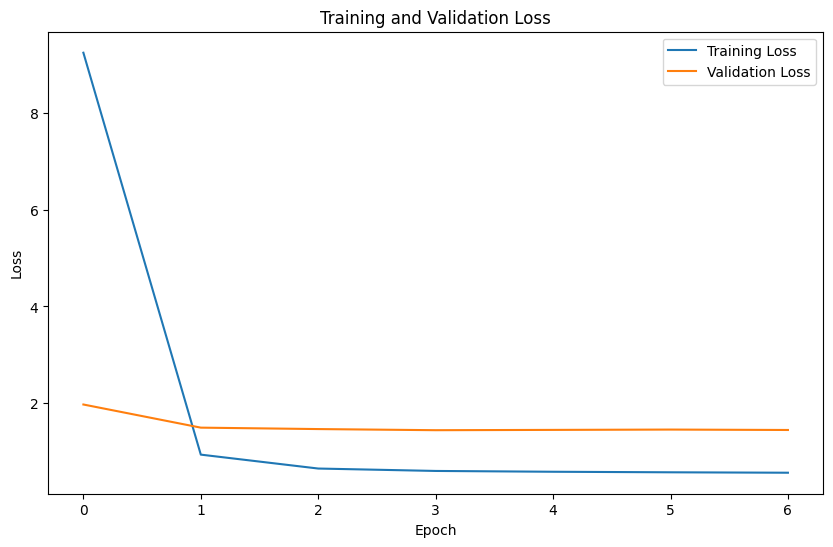

In [ ]:
model, train_losses, val_losses = train_model_enhanced(
    train_loader=train_loader,
    val_loader=val_loader,
    field_dims=field_dims,
    cat_features=cat_features,
    array_features=array_features,
    embedding_dim=hyperparams['embedding_dim'],
    mlp_dims=hyperparams['mlp_dims'],
    dropout=hyperparams['dropout'],
    learning_rate=hyperparams['learning_rate'],
    epochs=hyperparams['epochs'],
    patience=hyperparams['patience'],
    checkpoint_dir='deepfm_models',
    weight_decay = hyperparams['weight_decay'],
    lr_scheduler_factor = hyperparams['lr_scheduler_factor'],
    lr_scheduler_patience = hyperparams['lr_scheduler_patience'],
    scheduler_warmup_steps = hyperparams['scheduler_warmup_steps']
)

In [ ]:
def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluate the model on the test set with mixed precision
    """
    model.eval()
    test_loss = 0
    test_batches = 0
    all_targets = []
    all_predictions = []

    print("Beginning evaluation...")
    with torch.no_grad():
        for numerical, categorical, array_batches, targets in tqdm(test_loader, desc="Evaluating"):
            # Move data to device
            if numerical is not None:
                numerical = numerical.to(device, non_blocking=True)
            if categorical is not None:
                categorical = categorical.to(device, non_blocking=True)
            array_batches = {col: tensor.to(device, non_blocking=True) for col, tensor in array_batches.items()}
            targets = targets.to(device, non_blocking=True)

            # Forward pass with mixed precision
            with autocast():
                outputs = model(numerical, categorical, array_batches)
                loss = criterion(outputs, targets)

            # Update statistics
            test_loss += loss.item()
            test_batches += 1

            # Store predictions and targets
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

            # Free memory
            del numerical, categorical, array_batches, targets, outputs
            torch.cuda.empty_cache()

    # Calculate metrics
    avg_test_loss = test_loss / test_batches
    rmse = np.sqrt(np.mean((np.array(all_predictions) - np.array(all_targets)) ** 2))
    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_targets)))

    print(f"Test Loss: {avg_test_loss:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")

    return avg_test_loss, rmse, mae, all_targets, all_predictions

In [ ]:
test_data = pd.read_pickle(os.path.join(data_path, 'test_shrunk50cols.pkl'))

y_test = pd.read_pickle(os.path.join(data_path, 'y_test_scaled.pkl'))

test_dataset = DeepFMDataset(
    test_data,
    y_test,
    numerical,
    categorical,
    objects,
    array_features  # Pass the array_features dictionary
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    pin_memory=True,
    num_workers=4
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()

In [ ]:
# Cell: Run evaluation
import time
start_time = time.time()
print(f"Starting evaluation on {len(test_dataset)} test samples...")

avg_test_loss, rmse, mae, actual, predicted = evaluate_model(model, test_loader, criterion, device)

elapsed_time = time.time() - start_time
print(f"Evaluation completed in {elapsed_time:.2f} seconds")

Starting evaluation on 1598628 test samples...
Beginning evaluation...


Evaluating:   0%|          | 0/3123 [00:00<?, ?it/s]

In [ ]:
# Cell: Visualize results with detailed plots
def plot_evaluation_results(actual, predicted):
    """Create visualizations of model performance"""
    plt.figure(figsize=(16, 12))

    # Plot 1: Actual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(actual, predicted, alpha=0.3, color='blue', s=8)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title('Actual vs Predicted Ratings')
    plt.grid(True, alpha=0.3)

    # Plot 2: Histogram of errors
    plt.subplot(2, 2, 2)
    errors = np.array(predicted) - np.array(actual)
    plt.hist(errors, bins=50, alpha=0.7, color='green')
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title(f'Error Distribution (MAE: {mae:.4f}, RMSE: {rmse:.4f})')
    plt.grid(True, alpha=0.3)

    # Plot 3: Error density by actual rating
    plt.subplot(2, 2, 3)
    plt.hexbin(actual, errors, gridsize=50, cmap='Blues')
    plt.xlabel('Actual Rating')
    plt.ylabel('Prediction Error')
    plt.title('Error Density by Actual Rating')
    plt.colorbar(label='Count')

    # Plot 4: Distribution of actual vs predicted ratings
    plt.subplot(2, 2, 4)
    plt.hist(actual, bins=20, alpha=0.5, label='Actual Ratings', color='blue')
    plt.hist(predicted, bins=20, alpha=0.5, label='Predicted Ratings', color='red')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title('Distribution of Ratings')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'evaluation_results.png'), dpi=300)
    plt.show()

# Plot the results
plot_evaluation_results(actual, predicted)

In [ ]:
# Cell: Calculate and display additional metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def calculate_additional_metrics(actual, predicted):
    """Calculate additional metrics for recommendation systems"""
    # Basic metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual, predicted)

    # Rating-specific metrics
    actual_array = np.array(actual)
    pred_array = np.array(predicted)

    # Threshold predictions to the same range as the actual ratings
    min_rating = np.min(actual_array)
    max_rating = np.max(actual_array)
    pred_array_clamped = np.clip(pred_array, min_rating, max_rating)

    # Calculate accuracy within different thresholds
    within_half = np.mean(np.abs(actual_array - pred_array_clamped) <= 0.5)
    within_one = np.mean(np.abs(actual_array - pred_array_clamped) <= 1.0)

    # Calculate metrics for different rating ranges
    low_ratings = actual_array <= 2.0
    mid_ratings = (actual_array > 2.0) & (actual_array < 4.0)
    high_ratings = actual_array >= 4.0

    if np.sum(low_ratings) > 0:
        low_mae = mean_absolute_error(actual_array[low_ratings], pred_array[low_ratings])
    else:
        low_mae = float('nan')

    if np.sum(mid_ratings) > 0:
        mid_mae = mean_absolute_error(actual_array[mid_ratings], pred_array[mid_ratings])
    else:
        mid_mae = float('nan')

    if np.sum(high_ratings) > 0:
        high_mae = mean_absolute_error(actual_array[high_ratings], pred_array[high_ratings])
    else:
        high_mae = float('nan')

    # Create a table of results
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Within 0.5 Stars': within_half,
        'Within 1.0 Stars': within_one,
        'MAE (Ratings ≤ 2.0)': low_mae,
        'MAE (Ratings 2.0-4.0)': mid_mae,
        'MAE (Ratings ≥ 4.0)': high_mae
    }

    # Print the metrics table
    print("\n===== Model Performance Metrics =====")
    for metric, value in metrics.items():
        print(f"{metric.ljust(20)}: {value:.4f}")

    return metrics

# Calculate additional metrics
metrics = calculate_additional_metrics(actual, predicted)

In [ ]:
# Cell: Save evaluation results
import json
import os

# Save metrics and plots
results_dir = os.path.join(checkpoint_dir, 'evaluation_results')
os.makedirs(results_dir, exist_ok=True)

# Save metrics to JSON
with open(os.path.join(results_dir, 'metrics.json'), 'w') as f:
    json.dump({k: float(v) for k, v in metrics.items()}, f, indent=4)

# Save top N most accurately and inaccurately predicted samples
errors = np.abs(np.array(predicted) - np.array(actual))
most_accurate_indices = np.argsort(errors)[:100]  # Top 100 most accurate
least_accurate_indices = np.argsort(errors)[-100:]  # Top 100 least accurate

accuracy_samples = {
    'most_accurate': {
        'indices': most_accurate_indices.tolist(),
        'actual': [float(actual[i]) for i in most_accurate_indices],
        'predicted': [float(predicted[i]) for i in most_accurate_indices],
        'error': [float(errors[i]) for i in most_accurate_indices]
    },
    'least_accurate': {
        'indices': least_accurate_indices.tolist(),
        'actual': [float(actual[i]) for i in least_accurate_indices],
        'predicted': [float(predicted[i]) for i in least_accurate_indices],
        'error': [float(errors[i]) for i in least_accurate_indices]
    }
}

with open(os.path.join(results_dir, 'accuracy_samples.json'), 'w') as f:
    json.dump(accuracy_samples, f, indent=4)

print(f"Evaluation results saved to {results_dir}")
print("Model evaluation complete!")

In [ ]:
# Cell: Generate rating distribution analysis
plt.figure(figsize=(12, 10))

# Plot 1: Error distribution by rating value
plt.subplot(2, 1, 1)
ratings = np.arange(0.5, 5.5, 0.5)  # From 0.5 to 5.0 in 0.5 steps
rating_errors = []

for rating in ratings:
    # Find samples with this rating
    mask = np.isclose(np.array(actual), rating, atol=0.25)
    if np.sum(mask) > 0:
        # Calculate mean absolute error for this rating
        rating_error = np.mean(np.abs(np.array(predicted)[mask] - rating))
        rating_errors.append(rating_error)
    else:
        rating_errors.append(0)

plt.bar(ratings, rating_errors, width=0.4)
plt.xlabel('Rating')
plt.ylabel('Mean Absolute Error')
plt.title('Error by Rating Value')
plt.grid(True, alpha=0.3)

# Plot 2: Prediction bias by rating (over/under prediction)
plt.subplot(2, 1, 2)
rating_biases = []

for rating in ratings:
    # Find samples with this rating
    mask = np.isclose(np.array(actual), rating, atol=0.25)
    if np.sum(mask) > 0:
        # Calculate mean bias (positive means over-prediction)
        rating_bias = np.mean(np.array(predicted)[mask] - rating)
        rating_biases.append(rating_bias)
    else:
        rating_biases.append(0)

plt.bar(ratings, rating_biases, width=0.4, color='orange')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.xlabel('Rating')
plt.ylabel('Mean Bias (Predicted - Actual)')
plt.title('Prediction Bias by Rating')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'rating_analysis.png'), dpi=300)
plt.show()

In [ ]:
# Download evaluation results
print("Downloading evaluation results...")
if os.path.exists('deepfm_models/evaluation_results.png'):
    files.download('deepfm_models/evaluation_results.png')
if os.path.exists('deepfm_models/loss_curves.png'):
    files.download('deepfm_models/loss_curves.png')
if os.path.exists('deepfm_models/evaluation_results/metrics.json'):
    files.download('deepfm_models/evaluation_results/metrics.json')
